# Imports

In [1]:
import numpy as np
import tclab
import time
from datetime import datetime
import os

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import package_DBR
import package_LAB

from importlib import reload
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import LL_RT, PID_RT,IMC_Tuning, FF_RT
package_LAB=reload(package_LAB)

# TClab function

In [2]:
def run(SP, MV, DV, PV, Ts, FF, Man, MVI, MVP, MVD):
    # global i, t, MV, PV, DV, SP

    
    #sets MV and DV
    lab.Q1(MV[-1])
    lab.Q2(DV[-1])
    
    #appends the value of PV
    PV.append(lab.T1)
    
    #sleeps to let the TClab heat
    time.sleep(Ts)
    
    #prepares the data to draw these values
    l1.set_data(t, MV)
    l2.set_data(t, PV)
    l3.set_data(t, DV)
    l4.set_data(t, SP)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    
    #auto adjusts y axis
    if i > 1:
        ax1.set_ylim(myRound(np.min(MV), 5) - 5, myRound(np.max(MV), 5) + 5)
        ax2.set_ylim(myRound(min(np.min(PV), np.min(SP)), 5) - 5, myRound(max(np.max(PV), np.max(SP)), 5) + 5)
        ax3.set_ylim(myRound(np.min(DV), 5) - 5, myRound(np.max(DV), 5) + 5)        
    
    #prints the picture with the graphs
    display(fig)
    
    #takes the current time and makes it a string
    now = datetime.now()
    date_time = now.strftime("%Y-%m-%d-%Hh%M")
    
    #transforms these vectors into numpy arrays
    t_a = np.array(t)
    MV_a = np.array(MV)
    PV_a = np.array(PV)
    DV_a = np.array(DV)
    SP_a = np.array(SP)
    MVI_a = np.array(MVI)
    MVP_a = np.array(MVP)
    MVD_a = np.array(MVD)
    Man_a = np.array(Man)
    
    #stacks arrays vertically and then transposes them
    my_data = np.vstack((t_a.T, MV_a.T, MVP_a.T, MVI_a.T, MVD_a.T, SP_a.T, PV_a.T, DV_a.T, Man_a.T))
    my_data = my_data.T
    
    #Create path to store data into
    if (FF):
        if(Man):
            nameFile = 'Data/TCLab OLP + FF ' + date_time + '.txt'
        else:
            nameFile = 'Data/TCLab CLP + FF ' + date_time + '.txt'
    else:
        if(Man):
            nameFile = 'Data/TCLab OLP + no FF ' + date_time + '.txt'
        else:
            nameFile = 'Data/TCLab CLP + no FF ' + date_time + '.txt'
    
    #creates directory if it doesn't exist
    if not os.path.exists('Data'):
        os.makedirs('Data')
    #saves the file
    np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,SP,PV,DV,Man',comments='')

# Parameters

In [ ]:
TSim = 4000
Ts = 1
N = int(TSim / Ts) + 1

# DV MV PV 
DV0 = 40
MV0 = 100
PV0 = 45


# paramètres de ^P(s) 2eme ordre pouvant être considérer comme premier ordre 

Kp = 0.57353288531197
T1p = 184.504684095101
T2p= 1.78243605751087E-07
thetap=6.19336906382859

# paramètres de ^D(s) 2ème ordre 
Kd = 0.553358040201031
T1d= 172.259419274141
T2d= 22.1508608750117
thetad =0.533716544751782

#rapport des gains 
KFF = -Kd/Kp

#Coef PID
alpha= 2
gamma = 0.9
Kc,T_I,T_D = IMC_Tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print('Kc : ',Kc,'T_I : ',T_I,'T_D',T_D )

#limites
MV_MIN = 0
MV_MAX = 100

# Simulation vectors

In [ ]:
t = []
SP = []
DV = []
PV = []
E = []
MV = []
MV_P = []
MV_I = []
MV_D = []
MAN = []
MV_MAN = []

MVFFDelay = []
MVFFLL1 = []
MV_FF = []

PV_LL1 = []
PV_LL2 = []

MVDelayp = []
PV1p = []
PV2p = []

DVDelayd = []
PV1d = []
PV2d = []

# Paths

In [ ]:
# Select mode 

#selectmode="CLP_Rp_SP_NO_FF"
#selectmode="Rp_DV_NO_FF_C_Man"
#selectmode="Rp_DV_FF_C_Man"
#selectmode="Rp_DV_NO_FF_C_Auto"
selectmode="Rp_DV_FF_C_Auto"

In [ ]:
if selectmode=="CLP_Rp_SP_NO_FF": 
    # Closed loop response to a SP change
    ManPath = {0: False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0 + 10, TSim: PV0 + 10}
    DVPath = {0: DV0, 1500: DV0 + 20 , TSim: DV0 + 20}
    FF = False
    ManFF = False
    
elif selectmode=="Rp_DV_NO_FF_C_Man":
    # Response to DV : No FF and controller in manual mode
    ManPath = {0: False, 1: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = False
    ManFF = True
    
elif selectmode=="Rp_DV_FF_C_Man":
    # Response to DV : FF and controller in manual mode
    ManPath = {0: False, 1: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = True
    ManFF = True
    
elif selectmode=="Rp_DV_NO_FF_C_Auto":
    
    # Response to DV : No FF and controller in automatic mode
    ManPath = {0: False, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 1500: DV0 + 20, TSim: DV0 + 20}
    FF = False
    ManFF = False
    
elif selectmode=="Rp_DV_FF_C_Auto":
    
    # Response to DV : FF and controller in automatic mode
    ManPath = {0: False, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, 850: PV0, TSim: PV0}
    DVPath = {0: DV0, 100: DV0 + 20,200: DV0, TSim: DV0}
    FF = True
    ManFF = False

# TCLab Experiment

KeyboardInterrupt: 

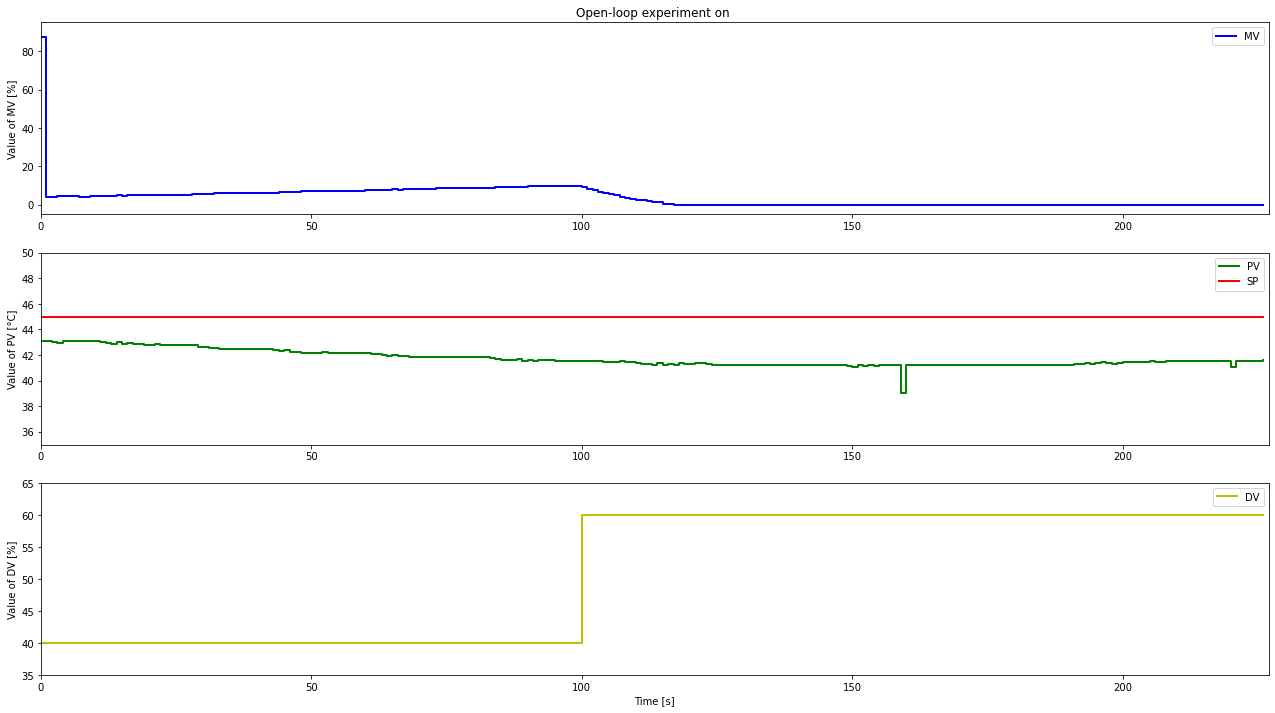

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Open-loop experiment on ')
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
l4, = ax2.step([0,1],[0,100],'r-',linewidth=2,label='SP',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'y-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best') 

lab = tclab.TCLab()
    
for i in range(0,N):
    t.append(i*Ts)
    
    # SP et DV creation
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath,t,DV)
    
   
    if FF== True:
        Delay_RT(DV - DV0 * np.ones_like(DV), np.max([thetad - thetap, 0]), Ts, MVFFDelay)
        LL_RT(MVFFDelay, KFF, T1p, T1d, Ts, MVFFLL1)
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MV_FF)
    else:
        LL_RT(DV,0,T2p,T2d,Ts,MV_FF)
    
    #mode manuel
    SelectPath_RT(ManPath,t,MAN)
    SelectPath_RT(MVManPath,t,MV_MAN)
    
    #PID
    PID_RT(SP,PV,MAN,MV_MAN,MV_FF,Kc,T_I,T_D,alpha,Ts,MV_MAX,MV_MIN,MV,MV_P,MV_I,MV_D,E,FF)
    

    run(SP, MV, DV, PV, Ts, FF, MAN, MV_I, MV_P, MV_D)

# Disconnect from TCLab
lab.close()

#save drawing of the plots
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")


if (FF):
    if(Man):
        nameFile = 'Plots/TCLab OLP + FF ' + date_time
    else:
        nameFile = 'Plots/TCLab CLP + FF ' + date_time
else:
    if(Man):
        nameFile = 'Plots/TCLab OLP + no FF ' + date_time
    else:
        nameFile = 'Plots/TCLab CLP + no FF ' + date_time


if not os.path.exists('Plots'):
    os.makedirs('Plots')
    
plt.savefig(nameFile + '.png',transparent=True)
plt.savefig(nameFile + '.pdf',transparent=True)    